In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
bucket = 'safetyhelmettestbucket' # custom bucket name.
# bucket = sess.default_bucket()
prefix = 'objectDetection'
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

arn:aws:iam::467343721842:role/service-role/AmazonSageMaker-ExecutionRole-20200521T183987
811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest
CPU times: user 649 ms, sys: 76.2 ms, total: 725 ms
Wall time: 761 ms


In [2]:
%%bash
rm -rf train
rm -rf train_annotation
rm -rf val
rm -rf val_annotation
mkdir train
mkdir train_annotation
mkdir val
mkdir val_annotation
cp JPEGImages/* train

In [3]:
from os import listdir
import os
import json
import xml.etree.cElementTree as ET

mypath = "Annotations"
jsonpath = "train_annotation"

files = listdir(mypath)

for f in files:
    
    fullfilename = mypath + '/' + f
    jsonfullfilename = jsonpath + '/' + f.replace("xml","json")
    line = {}
    
    tree = ET.ElementTree(file=fullfilename)
    root = tree.getroot()
    categories = {}
    for child in root:
        if child.tag == "filename":
            line["file"] = f.replace("xml","jpg")
        if child.tag == "size":
            line["image_size"] = []
            image_size = {}
            for s in child:
                if s.tag == "width":
                    image_size["width"] = int(s.text)
                elif s.tag == "height":
                    image_size["height"] = int(s.text)
                elif s.tag == "depth":
                    image_size["depth"] = int(s.text)
                else:
                    print(s.tag,":",s.text)
        
            line["image_size"].append(image_size)
            line["annotations"] = []            
            line["categories"] = []
            
        if child.tag == "object":
            annotation = {}
            for s in child:                           
                if s.tag == "bndbox": 
                    left = 0
                    right = 0
                    top = 0
                    bottom = 0
                    for ss in s:
                        if ss.tag == "xmin":
                            left = int(ss.text)
                        elif ss.tag == "xmax":
                            right = int(ss.text)
                        elif ss.tag == "ymin":
                            top = int(ss.text)
                        elif ss.tag == "ymax":
                            bottom = int(ss.text)
                    annotation["left"] = left
                    annotation["top"] = top
                    annotation["width"] = right - left
                    annotation["height"] = bottom - top
                if s.tag == "name":
                    category = {}
                    if s.text == "hat":
                        annotation["class_id"] = 0
                    elif s.text == "person":
                        annotation["class_id"] = 1
                    else:
                        annotation["class_id"] = 0
            line["annotations"].append(annotation)
    line["categories"].append({"class_id": 0, "name": "hat"})
    line["categories"].append({"class_id": 1, "name": "person"})
            
    if len(line["annotations"]) > 0 :
        with open(jsonfullfilename,"w") as p:
            json.dump(line,p)
    else:
        os.remove('train/' + f.replace("xml","jpg"))


In [4]:
import shutil
import os

json_files = os.listdir('train_annotation')

m = 4
i = 0
for f in json_files:
    i = i + 1
    jpgPath = 'train/' + f.replace("json", "jpg");
    if not os.path.exists(jpgPath):
        os.rename('train/' + f.replace("json", "JPG"), jpgPath)
    if i%m == 0:
        shutil.move(jsonpath + '/' + f, 'val_annotation/')
        filePath = f.replace("json","jpg")
        shutil.move('train/' + filePath, 'val/')

In [5]:
print ( "%d files in training folder." % len(os.listdir('train')))
print ( "%d files in val folder." % len(os.listdir('val')))

5686 files in training folder.
1895 files in val folder.


In [ ]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='val', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='val_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [ ]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [ ]:
od_model.set_hyperparameters(base_network='vgg-16',
                             use_pretrained_model=1,
                             num_classes=2,
                             mini_batch_size=16,
                             epochs=75,
                             learning_rate=0.01,
                             lr_scheduler_step='20,35,50',
                             lr_scheduler_factor=0.1,
                             optimizer='adam',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=2000,
                             num_training_samples=5686)

In [ ]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

In [ ]:
od_model.fit(inputs=data_channels, logs=True)

In [15]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m5.xlarge')

Using already existing model: object-detection-2020-05-29-12-19-04-319


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:467343721842:endpoint/object-detection-2020-05-29-12-19-04-319".

In [36]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = ["green","yellow","red"]

        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)

            if cls_id == 0 or cls_id == 1:       
                xmin = int(x0 * width)
                ymin = int(y0 * height)
                xmax = int(x1 * width)
                ymax = int(y1 * height)
                rect = plt.Rectangle((xmin, ymin), 
                                     xmax - xmin,
                                     ymax - ymin, 
                                     fill=False,
                                     edgecolor=colors[cls_id],
                                     linewidth=1.0)
                plt.gca().add_patch(rect)
                class_name = str(cls_id)
                if classes and len(classes) > cls_id:
                    class_name = classes[cls_id]
                plt.gca().text(xmin, ymin - 2,
                                '{:s} {:.3f}'.format(class_name, score),
                                bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                        fontsize=12, color='white')
        plt.show()

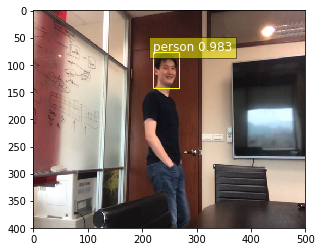

In [45]:
file_name = 'test/10.png'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

object_detector.content_type = 'image/png'
results = object_detector.predict(b)
detections = json.loads(results)
object_categories = ['helmet','person']
threshold = 0.6

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

In [38]:
def visualize_detection_adv(img_file, filename, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = ["green","yellow","red"]
        hasRect = False
        
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)

            if cls_id == 0 or cls_id == 1:
                hasRect = True
                xmin = int(x0 * width)
                ymin = int(y0 * height)
                xmax = int(x1 * width)
                ymax = int(y1 * height)
                rect = plt.Rectangle((xmin, ymin), 
                                     xmax - xmin,
                                     ymax - ymin, 
                                     fill=False,
                                     edgecolor=colors[cls_id],
                                     linewidth=1.0)
                plt.gca().add_patch(rect)
                class_name = str(cls_id)
                if classes and len(classes) > cls_id:
                    class_name = classes[cls_id]
                plt.gca().text(xmin, ymin - 2,
                                '{:s} {:.3f}'.format(class_name, score),
                                bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                        fontsize=12, color='white')
        if hasRect:
            plt.savefig(filename)
        plt.show()
        

In [39]:
%%bash
rm -rf ava_gen
mkdir ava_gen

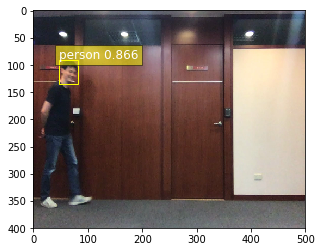

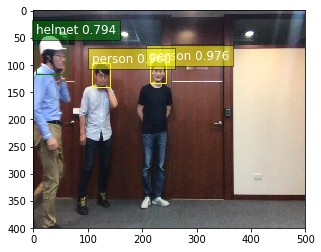

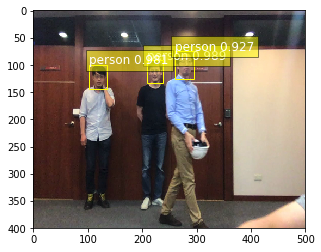

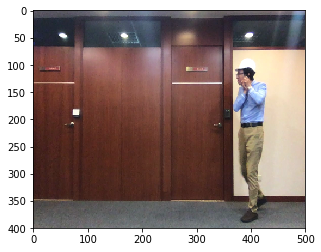

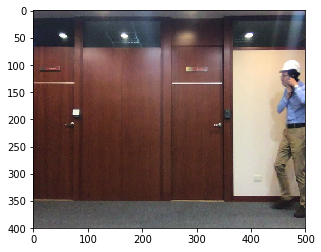

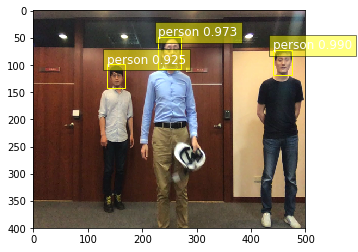

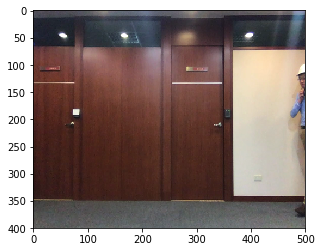

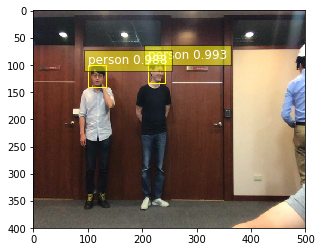

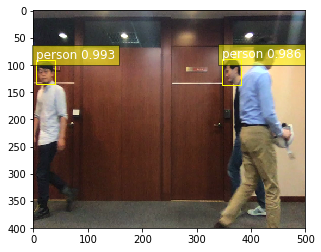

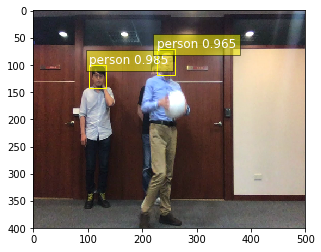

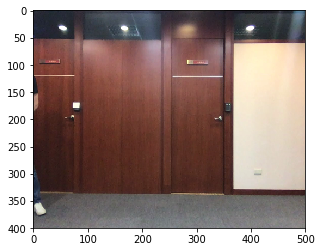

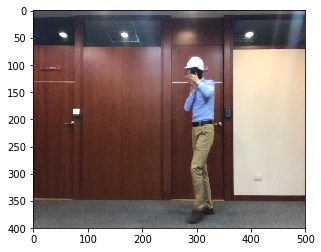

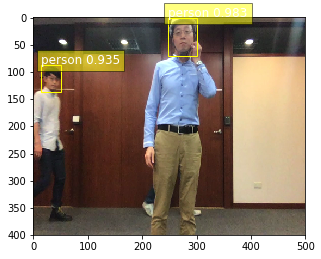

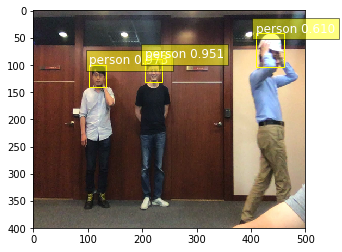

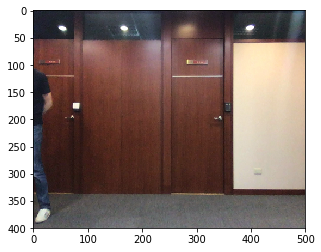

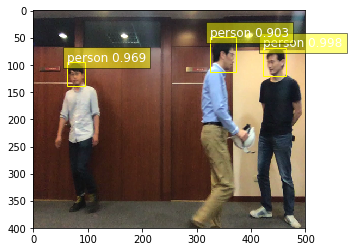

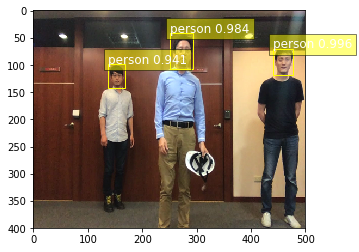

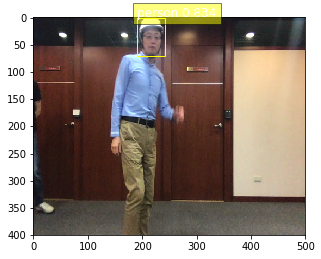

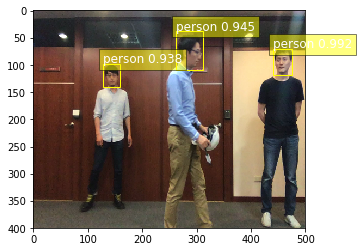

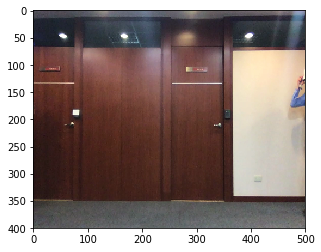

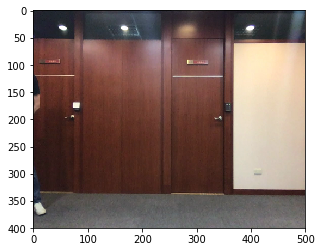

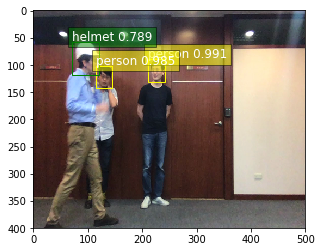

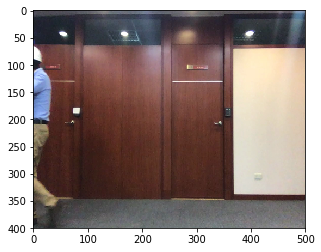

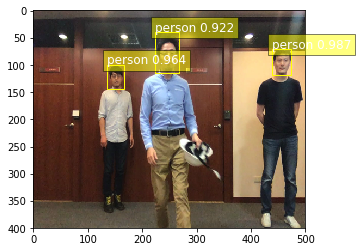

IsADirectoryError: [Errno 21] Is a directory: 'ava_test/.ipynb_checkpoints'

In [40]:
listTestFiles = listdir("ava_test")
#listTestFiles = ["rtsp-20200528-1056280600.png"]
for filename in listTestFiles:
    fullFilePath = "ava_test/" + filename
    altFullFilePath = "ava_gen/" + filename
    with open(fullFilePath, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        #ne = open('n.txt','wb')
        #ne.write(b)

        object_detector.content_type = 'image/png'
        results = object_detector.predict(b)
        detections = json.loads(results)
        object_categories = ['helmet', 'person']
        threshold = 0.6

        # Visualize the detections.
        visualize_detection_adv(fullFilePath, altFullFilePath, detections['prediction'], object_categories, threshold)
    

In [ ]:
import boto3

s3 = boto3.client('s3')
listGenFiles = listdir("ava_gen")
for filename in listGenFiles:
    if filename != ".ipynb_checkpoints":
        altFullFilePath = "ava_gen/" + filename
        with open(altFullFilePath, "rb") as f:
            s3.upload_fileobj(f, "kvs-img", filename)
    